In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torch.optim as optim
import time
import seaborn as sns
from torchvision import models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 32

# Load the Food-11 dataset with transforms without augmentation
train_dataset = torchvision.datasets.ImageFolder(root='./Food-11/training', transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root='./Food-11/validation', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='./Food-11/evaluation', transform=transform)

# Dataloaders for the Food-11 dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [3]:
# Check image channel if 1, grayscale image if 3, RGB image
for image,label in train_loader:
    print(image.shape[1])
    break

3


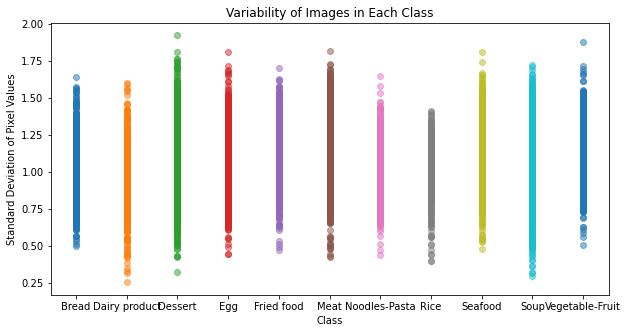

In [4]:
def plot_class_sample_variance(train_loader: DataLoader):
    classes = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
    class_variances = {class_name: [] for class_name in classes}

    # Iterate through each image
    for images, labels in train_loader:                                     
        for i, label in enumerate(labels):
            # Calculate and append the standard deviation of the pixel value
            class_variances[classes[label]].append(images[i].std().item())

    fig, ax = plt.subplots(figsize=(10, 5))
    for class_name, variances in class_variances.items():
        ax.scatter([class_name for _ in variances], variances, alpha=0.5)

    ax.set_title('Variability of Images in Each Class')
    ax.set_xlabel('Class')
    ax.set_ylabel('Standard Deviation of Pixel Values')

    plt.show()

plot_class_sample_variance(train_loader)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


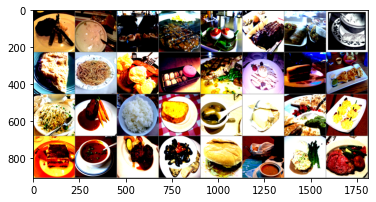

Meat            Soup            Egg             Meat            Egg             Meat            Bread           Soup            Egg             Noodles-Pasta   Dessert         Dessert         Meat            Dessert         Dessert         Bread           Rice            Meat            Rice            Bread           Soup            Dairy product   Bread           Egg             Dessert         Soup            Meat            Seafood         Bread           Soup            Meat            Meat           


In [5]:
classes = train_dataset.classes

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:15s}' for j in range(batch_size)))


In [6]:
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
torch.cuda.get_device_name(0)

'Tesla V100-PCIE-16GB'

In [8]:
torch.cuda.empty_cache()

In [26]:
def modelTraining(model, criterion, optimizer, earlyStopping=False):

    startTime = time.time()

    training_loss_plt_arr = []
    validation_loss_plt_arr = []
    testing_loss_plt_arr = []

    epochs = 10
    max_consecutive = 0
    consecutive_count = 0
    previous_number = float('inf')

    for epoch in range(epochs):
        model.train()  # Set the model to training mode

        training_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            labels = labels.flatten()
            loss_training = criterion(outputs, labels)
            loss_training.backward()
            optimizer.step()

            training_loss += loss_training.item()

        # Calculate validation loss
        model.eval()  # Set the model to evaluation mode
        validation_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                labels = labels.flatten()
                loss_validation = criterion(outputs, labels)
                validation_loss += loss_validation.item()
                
        # Calculate testing loss
        testing_loss = 0.0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                labels = labels.flatten()
                loss_testing = criterion(outputs, labels)
                testing_loss += loss_testing.item()
                
        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{epochs}] - Training Loss: {training_loss / len(train_loader):.3f} - Validation Loss: {validation_loss / len(val_loader):.3f} - Testing Loss: {testing_loss / len(test_loader):.3f}")

        # Store losses for plotting
        training_loss_plt_arr.append(training_loss / len(train_loader))
        validation_loss_plt_arr.append(validation_loss / len(val_loader))
        testing_loss_plt_arr.append(testing_loss / len(test_loader))

        # Early stopping condition
        if earlyStopping:
            if validation_loss < previous_number:
                previous_number = validation_loss
                consecutive_count = 0
            else:
                consecutive_count += 1
                max_consecutive = max(
                    max_consecutive, consecutive_count)
                if max_consecutive == 5:
                    print(
                        "\nStopping training as Validation Loss stopped improving.")
                    break

        if earlyStopping:
            if max_consecutive == 5:
                break

    print("Finished Training")

    endTime = time.time()
    time_to_train = (endTime - startTime)

    # Convert total time to minutes and seconds
    minutes = int(time_to_train // 60)
    seconds = int(time_to_train % 60)

    print(f"\nTime to train: {minutes}min {seconds}sec")

    return training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr

In [27]:
# Losses visualisation
def LossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr):
    lenLoss = len(training_loss_plt_arr) + 1
    # Plot the loss graph
    plt.plot(range(1, lenLoss), training_loss_plt_arr,
             label='Training Loss', color='red')
    plt.plot(range(1, lenLoss), validation_loss_plt_arr,
             label='Validation Loss', color='green')
    plt.plot(range(1, lenLoss), testing_loss_plt_arr,
             label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation vs Testing loss')
    plt.legend()
    plt.show()

In [28]:
# Updated Performance Evaluation
def loadersAccuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    trueLabels, predictedLabels = [], []
    trueLabelsROC, predictedLabelsROC = [], []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            # Move images and labels to GPU
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.flatten()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            trueLabels.extend(labels.tolist())
            predictedLabels.extend(predicted.tolist())
            # ROC
            preds = F.softmax(outputs, dim=1)
            trueLabelsROC.extend(labels.tolist())
            predictedLabelsROC.extend(preds.tolist())

    accuracy = (correct / total * 100)
    return accuracy, trueLabels, predictedLabels, trueLabelsROC, predictedLabelsROC


def perfEvaluation(model):
    model.eval()

    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels, test_trueLabelsROC, test_predictedLabelsROC = loadersAccuracy(
        test_loader, model)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")

    valid_accuracy, _, _, _, _ = loadersAccuracy(val_loader, model)
    train_accuracy, _, _, _, _ = loadersAccuracy(train_loader, model)

    # Convert labels and predicted from list to tensor for metric calucaltions
    test_predictedLabels = torch.tensor(test_predictedLabels)
    test_trueLabels = torch.tensor(test_trueLabels)
    test_trueLabelsROC = torch.tensor(test_trueLabelsROC)
    test_predictedLabelsROC = torch.tensor(test_predictedLabelsROC)

    # Precision, Recall, Fscore
    precision, recall, fscore, _ = precision_recall_fscore_support(
        test_trueLabels, test_predictedLabels, average='weighted')
    print(f"Precision = {precision:.2f}")
    print(f"Recall = {recall:.2f}")
    print(f"Fscore = {fscore:.2f}")

    # Plot the Accuracies
    labels = ['Training', 'Validation', 'Test']
    accuracies = [train_accuracy, valid_accuracy, test_accuracy]
    plt.bar(labels, accuracies, color=['red', 'green', 'blue'])
    plt.xlabel('Splits')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    for i, v in enumerate(accuracies):
        plt.text(i, v + 1, f'{v:.2f}', color='black', ha='center')
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(test_trueLabels, test_predictedLabels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

    # Plot ROC Curve
    metric = MulticlassROC(num_classes=len(classes))
    metric.update(test_predictedLabelsROC, test_trueLabelsROC)
    metric.plot(score=True)

Epoch [1/10] - Training Loss: 1.319 - Validation Loss: 1.719 - Testing Loss: 1.642
Epoch [2/10] - Training Loss: 0.906 - Validation Loss: 1.052 - Testing Loss: 0.962
Epoch [3/10] - Training Loss: 0.736 - Validation Loss: 1.332 - Testing Loss: 1.249
Epoch [4/10] - Training Loss: 0.596 - Validation Loss: 0.782 - Testing Loss: 0.734
Epoch [5/10] - Training Loss: 0.479 - Validation Loss: 0.773 - Testing Loss: 0.690
Epoch [6/10] - Training Loss: 0.411 - Validation Loss: 1.196 - Testing Loss: 1.012
Epoch [7/10] - Training Loss: 0.356 - Validation Loss: 0.847 - Testing Loss: 0.737
Epoch [8/10] - Training Loss: 0.262 - Validation Loss: 0.773 - Testing Loss: 0.640
Epoch [9/10] - Training Loss: 0.215 - Validation Loss: 1.269 - Testing Loss: 1.148
Epoch [10/10] - Training Loss: 0.190 - Validation Loss: 0.849 - Testing Loss: 0.748
Finished Training

Time to train: 20min 19sec


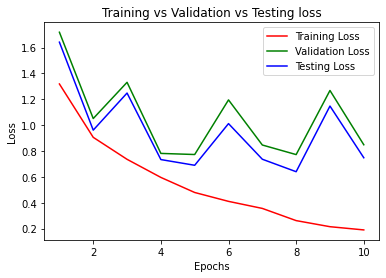

Accuracy on the testing dataset = 77.17
Precision = 0.79
Recall = 0.77
Fscore = 0.77


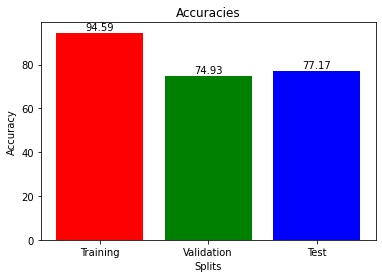

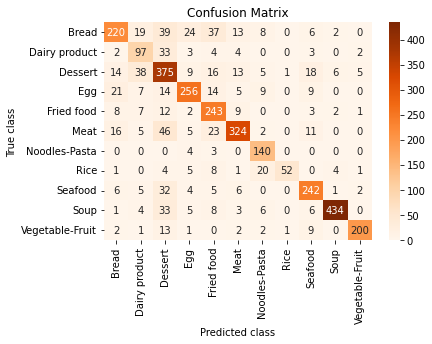

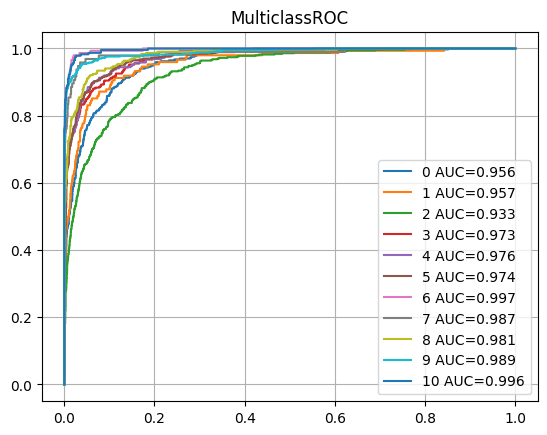

In [29]:
modelRes = models.resnet50(pretrained=True)
num_ftrs = modelRes.fc.in_features
num_classes = len(classes)
modelRes.fc = nn.Linear(num_ftrs, num_classes)

modelRes.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelRes.parameters(), lr=0.001)

training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=modelRes, criterion=criterion,
                                                                                    optimizer=optimizer, earlyStopping=False)
LossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=modelRes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /user/ngupta22/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


Epoch [1/10] - Training Loss: 1.093 - Validation Loss: 1.503 - Testing Loss: 1.347
Epoch [2/10] - Training Loss: 0.744 - Validation Loss: 1.653 - Testing Loss: 1.496
Epoch [3/10] - Training Loss: 0.545 - Validation Loss: 1.018 - Testing Loss: 0.933
Epoch [4/10] - Training Loss: 0.421 - Validation Loss: 0.738 - Testing Loss: 0.666
Epoch [5/10] - Training Loss: 0.328 - Validation Loss: 0.983 - Testing Loss: 0.836
Epoch [6/10] - Training Loss: 0.255 - Validation Loss: 1.394 - Testing Loss: 1.193
Epoch [7/10] - Training Loss: 0.215 - Validation Loss: 0.970 - Testing Loss: 0.819
Epoch [8/10] - Training Loss: 0.172 - Validation Loss: 1.089 - Testing Loss: 0.824
Epoch [9/10] - Training Loss: 0.149 - Validation Loss: 1.015 - Testing Loss: 0.878
Epoch [10/10] - Training Loss: 0.144 - Validation Loss: 0.951 - Testing Loss: 0.812
Finished Training

Time to train: 18min 7sec


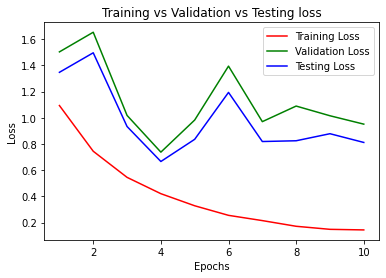

Accuracy on the testing dataset = 80.22
Precision = 0.81
Recall = 0.80
Fscore = 0.80


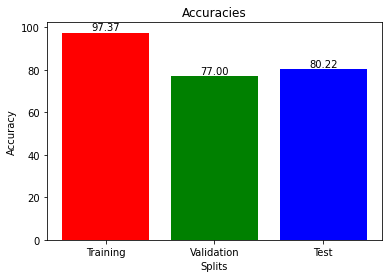

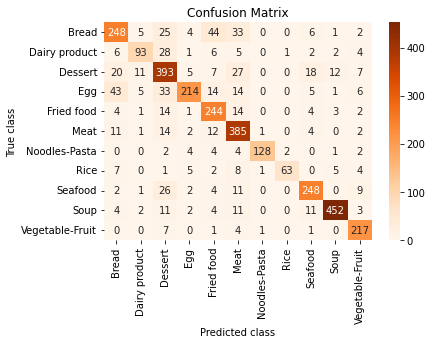

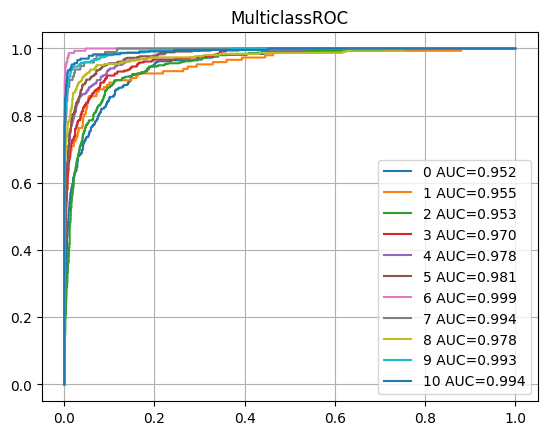

In [32]:
modelRes18 = models.resnet18(pretrained=True)
num_ftrs = modelRes18.fc.in_features
num_classes = len(classes)
modelRes18.fc = nn.Linear(num_ftrs, num_classes)

modelRes18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelRes18.parameters(), lr=0.001)

training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=modelRes18, criterion=criterion,
                                                                                    optimizer=optimizer, earlyStopping=False)
LossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=modelRes18)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /user/ngupta22/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100.0%


Epoch [1/10] - Training Loss: 0.984 - Validation Loss: 0.782 - Testing Loss: 0.745
Epoch [2/10] - Training Loss: 0.666 - Validation Loss: 0.700 - Testing Loss: 0.595
Epoch [3/10] - Training Loss: 0.511 - Validation Loss: 0.924 - Testing Loss: 0.857
Epoch [4/10] - Training Loss: 0.430 - Validation Loss: 0.635 - Testing Loss: 0.526
Epoch [5/10] - Training Loss: 0.377 - Validation Loss: 0.608 - Testing Loss: 0.513
Epoch [6/10] - Training Loss: 0.302 - Validation Loss: 0.821 - Testing Loss: 0.714
Epoch [7/10] - Training Loss: 0.292 - Validation Loss: 0.641 - Testing Loss: 0.550
Epoch [8/10] - Training Loss: 0.223 - Validation Loss: 0.590 - Testing Loss: 0.536
Epoch [9/10] - Training Loss: 0.196 - Validation Loss: 1.007 - Testing Loss: 0.784
Epoch [10/10] - Training Loss: 0.219 - Validation Loss: 0.785 - Testing Loss: 0.696
Finished Training

Time to train: 23min 1sec


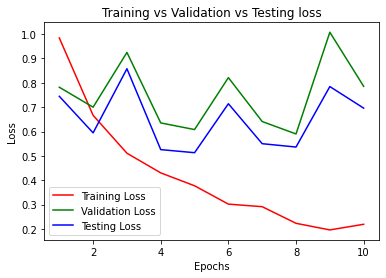

Accuracy on the testing dataset = 81.95
Precision = 0.83
Recall = 0.82
Fscore = 0.82


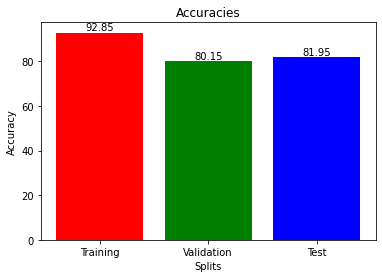

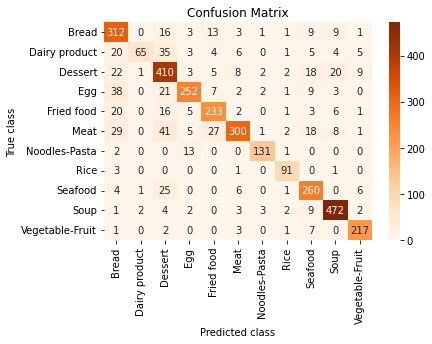

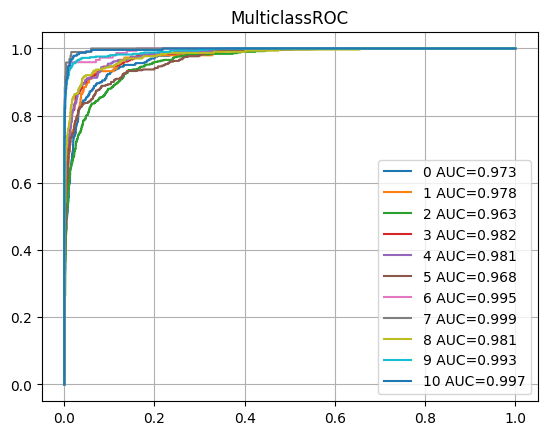

In [34]:
modelDense = models.densenet121(pretrained=True)
num_ftrs = modelDense.classifier.in_features
num_classes = len(classes)
modelDense.classifier = nn.Linear(num_ftrs, num_classes)

modelDense.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelDense.parameters(), lr=0.001)

training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=modelDense, criterion=criterion,
                                                                                    optimizer=optimizer, earlyStopping=False)
LossesPlot(training_loss_plt_arr,
        validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=modelDense)

## Best Model with Regularization
Out of the above three models, Densenet121 model gave the best accuracy(81.95%). Therefore, we would be selecting densenet121 model and add regularization to it as hyperparameter tuning.

Epoch [1/10] - Training Loss: 1.024 - Validation Loss: 1.012 - Testing Loss: 0.938
Epoch [2/10] - Training Loss: 0.751 - Validation Loss: 1.133 - Testing Loss: 1.066
Epoch [3/10] - Training Loss: 0.683 - Validation Loss: 0.860 - Testing Loss: 0.792
Epoch [4/10] - Training Loss: 0.624 - Validation Loss: 0.845 - Testing Loss: 0.752
Epoch [5/10] - Training Loss: 0.583 - Validation Loss: 1.164 - Testing Loss: 1.014
Epoch [6/10] - Training Loss: 0.552 - Validation Loss: 0.878 - Testing Loss: 0.775
Epoch [7/10] - Training Loss: 0.532 - Validation Loss: 0.725 - Testing Loss: 0.628
Epoch [8/10] - Training Loss: 0.506 - Validation Loss: 0.844 - Testing Loss: 0.745
Epoch [9/10] - Training Loss: 0.485 - Validation Loss: 0.666 - Testing Loss: 0.594
Epoch [10/10] - Training Loss: 0.454 - Validation Loss: 0.745 - Testing Loss: 0.664
Finished Training

Time to train: 23min 29sec


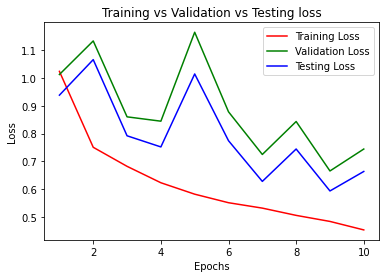

Accuracy on the testing dataset = 78.28
Precision = 0.82
Recall = 0.78
Fscore = 0.78


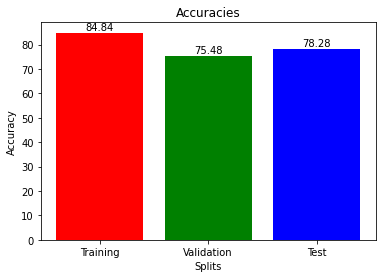

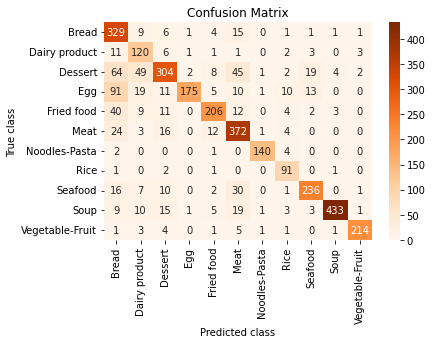

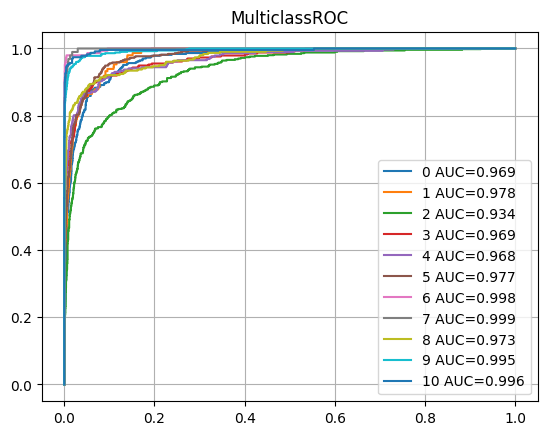

In [35]:
modelDense_Reg = models.densenet121(pretrained=True)
num_ftrs = modelDense_Reg.classifier.in_features
num_classes = len(classes)
modelDense_Reg.classifier = nn.Linear(num_ftrs, num_classes)

modelDense_Reg.to(device)

# Regularization (L2)
l2_reg = 0.001
criterion_Reg = nn.CrossEntropyLoss()
optimizer_Reg = optim.Adam(modelDense_Reg.parameters(), lr=0.001, weight_decay=l2_reg)

training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=modelDense_Reg, criterion=criterion_Reg,
                                                                                    optimizer=optimizer_Reg, earlyStopping=False)
LossesPlot(training_loss_plt_arr,
        validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=modelDense_Reg)

## We can see in the above model with Regularization, the overfitting has significantly decreased.